In [ ]:
# Downloading useful data
!wget --quiet https://github.com/LSSTDESC/star-challenge/raw/main/cosmodc2-srd-sample/generation/shear_photoz_stack.hdf5

     |████████████████████████████████| 283 kB 9.3 MB/s 
     |████████████████████████████████| 283 kB 60.6 MB/s 
     |████████████████████████████████| 259 kB 7.4 MB/s 
     |████████████████████████████████| 309 kB 19.8 MB/s 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline
import h5py

import jax
import jax.numpy as jnp
import jax_cosmo as jc
from jax_cosmo.scipy.integrate import simps
import astropy.units as u

from bpcosmo.pm import get_density_planes

from jaxpm.lensing import density_plane, convergence_Born

import numpyro
import numpyro.distributions as dist

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Hyperparameters of the simulation

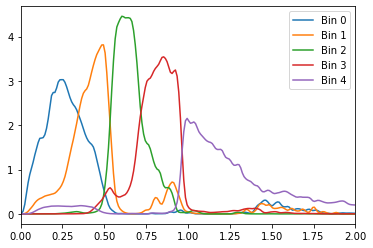

In [6]:
# Reading the DC2 tomographic bins into redshift distribution objects
with h5py.File("shear_photoz_stack.hdf5") as f:
    group = f["n_of_z"]
    # Read the z grid
    source = group["source"]
    z_shear = source['z'][::]
    # Read the true n(z)
    nz_shear = [jc.redshift.kde_nz(z_shear,  
                                   source[f"bin_{i}"][:], 
                                   bw=0.01, zmax=2.5) for i in range(5)] 
for i in range(5):
  plot(z_shear, nz_shear[i](z_shear), color='C%d'%i, label="Bin %d"%i)
legend()
xlim(0,2);

### Definition of the forward model

In [10]:
def forward_model(box_size=[400.,400.,4000.], # In Mpc/h
                  nc = [64, 64, 640],         # Number of pixels
                  field_size = 20,            # Size of the lensing field in degrees
                  field_npix = 128,           # Number of pixels in the lensing field
                  sigma_e = 0.25,             # Standard deviation of galaxy ellipticities
                  galaxy_density = 10.,       # Galaxy density per arcmin^2, per redshift bin
                  ):
  """
  This function defines the top-level forward model for our observations
  """
  # Sampling cosmological parameters and defines cosmology
  Omega_c = numpyro.sample('Omega_c', dist.Uniform(0.1, 0.9))
  sigma8 = numpyro.sample('sigma8', dist.Uniform(0.4, 1.0))
  Omega_b = numpyro.sample('Omega_b', dist.Uniform(0.03, 0.07))
  h = numpyro.sample('h', dist.Uniform(0.55, 0.91))
  n_s = numpyro.sample('n_s', dist.Uniform(0.87, 1.07)) 
  w0 = numpyro.sample('w0', dist.Uniform(-2.0, -0.33))
  cosmo = jc.Cosmology(Omega_c=Omega_c, sigma8=sigma8, Omega_b=Omega_b,
                       h=h, n_s=n_s, w0=w0, Omega_k=0., wa=0.)

  # Generate lightcone density planes through an nbody
  density_planes = get_density_planes(cosmo, box_size=box_size, nc=nc)

  # Create photoz systematics parameters, and create derived nz 
  nzs_s_sys = [jc.redshift.systematic_shift(nzi, 
                                            numpyro.sample('dz%d'%i, dist.Normal(0., 0.01)), 
                                            zmax=2.5) 
                for i, nzi in enumerate(nz_shear)]

  # Defining the coordinate grid for lensing map
  xgrid, ygrid = np.meshgrid(np.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                             np.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates
  coords = jnp.array((np.stack([xgrid, ygrid], axis=0)*u.deg).to(u.rad))
    
  # Generate convergence maps by integrating over nz and source planes
  convergence_maps = [simps(lambda z: nz(z).reshape([-1,1,1]) * 
                              convergence_Born(cosmo, density_planes, coords, z), 0., 2.5, N=64) 
                      for nz in nzs_s_sys]

  # Apply noise to the maps (this defines the likelihood)
  observed_maps = [numpyro.sample('kappa_%d'%i, 
                                  dist.Normal(k, sigma_e/jnp.sqrt(10**2*galaxy_density))) # assumes pixel size of 10 arcmin
                   for i,k in enumerate(convergence_maps)]

  return observed_maps
                    kappa

Once the model is defined, it needs to be seeded, and then can be ran and traced if one wants to access all the stochastic variables.

In [11]:
# Fixes the random seed for the model
seeded_model = numpyro.handlers.seed(forward_model, jax.random.PRNGKey(0))

# It can then be used directly as a function
observations = seeded_model()

# Or can be fully traces 
trace = numpyro.handlers.trace(seeded_model).get_trace()

/home/francois/.local/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


Let's have a look at the simulated fields

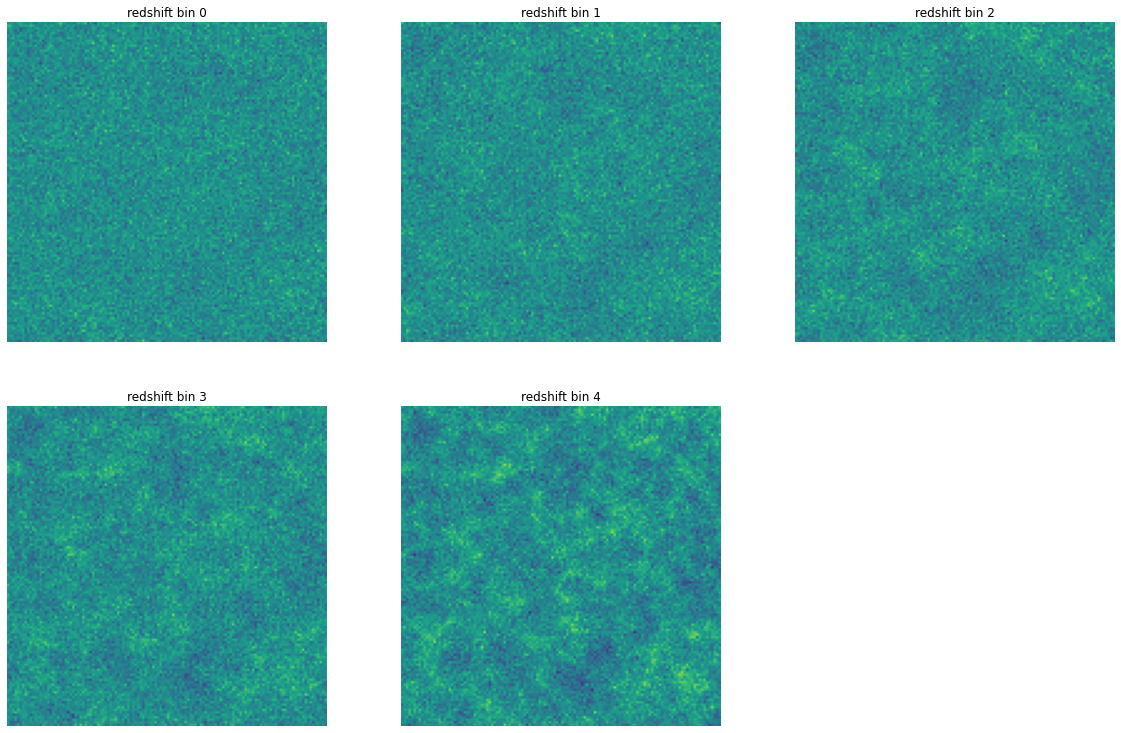

In [12]:
figure(figsize=[20,20])
for i in range(5):
    subplot(3,3,i+1)
    title('redshift bin %d'%i)
    imshow(trace['kappa_%d'%i]['value'],vmax=0.05,vmin=-0.05)
    axis('off')

But if we want we can also retrieve from the trace the underlying convergence field

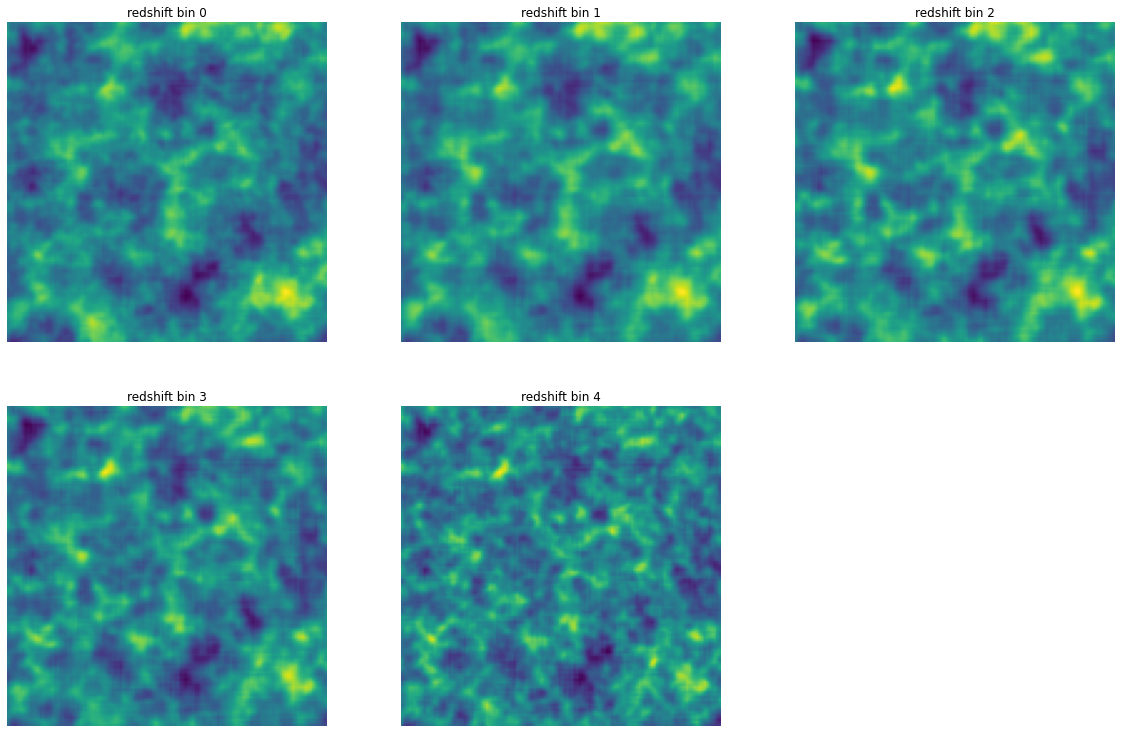

In [13]:
figure(figsize=[20,20])
for i in range(5):
    subplot(3,3,i+1)
    title('redshift bin %d'%i)
    imshow(trace['kappa_%d'%i]['fn'].mean)
    axis('off')

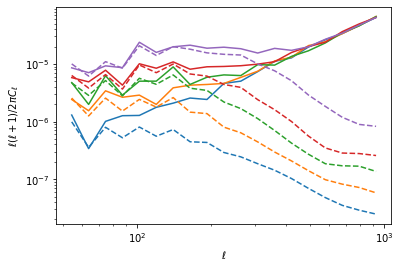

In [14]:
from lenstools import ConvergenceMap
l_edges_kmap = np.logspace(1.7,3,20)
for i in range(5):
  map = ConvergenceMap(trace['kappa_%d'%i]['value'], angle=field_size*u.deg)
  l_k,Pl_k = map.powerSpectrum(l_edges_kmap)
  loglog(l_k, l_k*(l_k+1)/(2*pi)*Pl_k, color='C%d'%i)

  map = ConvergenceMap(trace['kappa_%d'%i]['fn'].mean, angle=field_size*u.deg)
  l_k,Pl_k = map.powerSpectrum(l_edges_kmap)
  loglog(l_k, l_k*(l_k+1)/(2*pi)*Pl_k, '--', color='C%d'%i)

xlabel(r'$\ell$');
ylabel(r'$\ell (\ell +1 )/2\pi C_\ell$');